# Imports

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.nn import DataParallel
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random

from pytorch_segmentation.data.train_dataset import TrainDataset
from pytorch_segmentation.data.inmemory_dataset import InMemorySatDataset
from pytorch_segmentation.train_net import train
from pytorch_segmentation.models import UNet
from pytorch_segmentation.losses.dice import DiceLoss
from pytorch_segmentation.losses.tversky import TverskyLoss
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:

#Rwanda data 2008
shape_path_rw_2008 = "data/datasets/V12/data_pool/rwanda_tree_shapes/Training_Data_manual_Trial29_V9_2008.shp"
train_data_path_rw_2008 = "data/datasets/V12/train/rwanda_2008"
val_data_path_rw_2008 = "data/datasets/V12/val/rwanda_2008"
test_data_path_rw_2008 = "data/datasets/V12/test/rwanda_2008"

#Rwanda data 2019
shape_path_rw_2019 = "data/datasets/V12/data_pool/rwanda_tree_shapes/Training_Data_manual_Trial29_V9_2020.shp"
train_data_path_rw_2019 = "data/datasets/V12/train/rwanda_2019"
val_data_path_rw_2019 = "data/datasets/V12/val/rwanda_2019"
test_data_path_rw_2019 = "data/datasets/V12/test/rwanda_2019"


tensorboard_path = "/home/jovyan/work/notebooks/runs"

# patch_size = [364,364,3]# [x,y,bands]
# overlap = 300

# patch_size = [321,321,3]# [x,y,bands]
# overlap = 270


patch_size = [300,300]# [x,y,bands]
overlap = 260

val_patch_size = [256,256]# [x,y,bands]
val_overlap = 200

test_patch_size = [256,256]
overlap_test = 128

padding = False#True

epochs = 500#25

early_stopping = None

dropout = True

scheduler_warmup= 20#10
sched_step = 15
sched_gamma = 0.1

#batch_size = 200
#batch_size = 50
batch_size = 50 #50 #150 #75

lr = 1e-3
weight_decay = 1e-3

weighted = False
weight = 0.2
sampler_replacement = True

metric = "iou"

n_channels = 3

nworkers = 4
pin_memory = True

nimgs = 4

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

save_dir = "saved_models"


# transform = seg_transforms.Compose([
#     seg_transforms.CLAHE_Norm(),
#     seg_transforms.RandomRotation(17),
#     seg_transforms.RandomHorizontalFlip(0.5),
#     seg_transforms.RandomVerticalFlip(0.5),
#     seg_transforms.CenterCrop(256),
#     seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.35),contrast=0.5,saturation=0.2),
#     # seg_transforms.ColorJitter(brightness=(0.9,1.15),contrast=0.2,saturation=0.1),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])

# #for 300,300 images
# transform = seg_transforms.Compose([
#     #seg_transforms.CLAHE_Norm(),
#     seg_transforms.Pad(100),
#     seg_transforms.RandomRotation(360),
#     seg_transforms.CenterCrop(282),
#     seg_transforms.RandomResizeCrop((256,256),(0.125,1)),
#     #seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.4),saturation=0.2),
#     #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])


transform_rw_2008 = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(0.25,1)),
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.4),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=0.8),
    seg_transforms.CenterCrop(256)
])


transform_rw_2019 = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(1,1)),
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=0.8),
    seg_transforms.CenterCrop(256)
])


# #for 300,300 images
# transform = seg_transforms.Compose([
#     #seg_transforms.CLAHE_Norm(),
#     seg_transforms.Pad(100),
#     seg_transforms.RandomRotation(360),
#     seg_transforms.CenterCrop(282),
#     seg_transforms.RandomResizeCrop((256,256),(0.5,1)),
#     #seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.4),saturation=0.2),
#     #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])


### For 321,321 patches with 270 overlap
# transform = seg_transforms.Compose([
#     #seg_transforms.CLAHE_Norm(),
#     seg_transforms.Pad(79),
#     seg_transforms.RandomRotation(360),
#     seg_transforms.CenterCrop(282),
#     seg_transforms.RandomCrop(256),
#     #seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.8,1.4),saturation=0.2),
#     #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])


val_transform = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    # seg_transforms.RandomHorizontalFlip(0.5),
    # seg_transforms.RandomVerticalFlip(0.5),
    #seg_transforms.UnmaskEdges([225,225])
#         seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349])
])

test_transform = None


# 1.1 Data Collection

#### Create Training and Test Dataset - Rwanda 2008

In [4]:
train_dataset_rw_2008 = TrainDataset(dataset_path=None,data_file_path=train_data_path_rw_2008,
                   shape_path=shape_path_rw_2008,
                             overlap=overlap,patch_size=patch_size,padding=padding,transform=transform_rw_2008)
val_dataset_rw_2008 = TrainDataset(dataset_path=None,data_file_path=val_data_path_rw_2008,
                   shape_path=shape_path_rw_2008,
                             overlap=val_overlap,patch_size=val_patch_size,padding=padding,transform=val_transform)
# test_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=test_data_path_rw,
#                    shape_path=shape_path_rw, overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)

print("Len Train: ",len(train_dataset_rw_2008))
print("Len Val: ",len(val_dataset_rw_2008))
#print("Len Test: ",len(test_dataset_rw))

 83%|████████▎ | 82/99 [00:39<00:08,  2.12it/s]

Shape data/datasets/V12/train/rwanda_2008/image_29_4ESE1R.tif.tif is too small for patch size with size: (3, 258, 451)


100%|██████████| 39/39 [00:16<00:00,  2.38it/s]


Len Train:  49775
Len Val:  9668


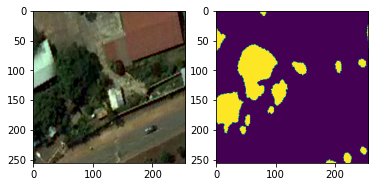

In [5]:
train_dataset_rw_2008.show_tuple(500)

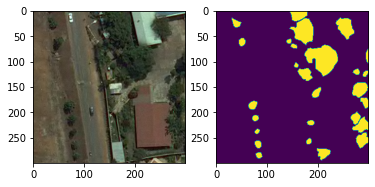

In [6]:
train_dataset_rw_2008.show_tuple(500,transform=False)

#### Create Training and Test Dataset - Rwanda 2019

In [7]:
train_dataset_rw_2019 = TrainDataset(dataset_path=None,data_file_path=train_data_path_rw_2019,
                   shape_path=shape_path_rw_2019,
                             overlap=overlap,patch_size=patch_size,padding=padding,transform=transform_rw_2019)
val_dataset_rw_2019 = TrainDataset(dataset_path=None,data_file_path=val_data_path_rw_2019,
                   shape_path=shape_path_rw_2019,
                             overlap=val_overlap,patch_size=val_patch_size,padding=padding,transform=val_transform)
# test_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=test_data_path_rw,
#                    shape_path=shape_path_rw, overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)

print("Len Train: ",len(train_dataset_rw_2019))
print("Len Val: ",len(val_dataset_rw_2019))
#print("Len Test: ",len(test_dataset_rw))

 34%|███▍      | 27/80 [00:10<00:16,  3.18it/s]

Shape data/datasets/V12/train/rwanda_2019/image_370_19.tif is too small for patch size with size: (3, 216, 602)


 64%|██████▍   | 51/80 [00:22<00:09,  3.08it/s]

Shape data/datasets/V12/train/rwanda_2019/image_410_19.tif is too small for patch size with size: (3, 296, 885)


100%|██████████| 24/24 [00:10<00:00,  2.34it/s]


Len Train:  43952
Len Val:  7591


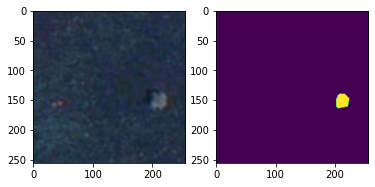

In [8]:
train_dataset_rw_2019.show_tuple(500)

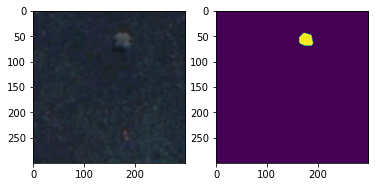

In [9]:
train_dataset_rw_2019.show_tuple(500,transform=False)

# 2. Model Training


In [10]:
from pytorch_segmentation.utils.sampling import create_weighted_dataset

train_dataset,weights = create_weighted_dataset([train_dataset_rw_2008,train_dataset_rw_2019],weight=weight)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=sampler_replacement) 

val_dataset = torch.utils.data.ConcatDataset([val_dataset_rw_2008,val_dataset_rw_2019])
#test_dataset = torch.utils.data.ConcatDataset([test_dataset_rw, test_dataset_sa])

In [11]:
if weighted:
    train_dl =DataLoader(train_dataset,sampler=sampler,batch_size=batch_size,num_workers=nworkers,shuffle=False,pin_memory=pin_memory,
                      drop_last=True)
else:
    train_dl =DataLoader(train_dataset,batch_size=batch_size,num_workers=nworkers,shuffle=True,pin_memory=pin_memory,
                  drop_last=True)

if (len(val_dataset) % batch_size) < nimgs:
    val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=True,pin_memory=pin_memory,drop_last=True)
else:
    val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=nworkers,
                         shuffle=True,pin_memory=pin_memory,drop_last=False)
# test_dl = DataLoader(test_dataset,batch_size=batch_size,num_workers=nworkers,
#                      shuffle=False,pin_memory=pin_memory,drop_last=False)

## 2.2 Advanced Unet 
https://github.com/milesial/Pytorch-UNet

In [13]:
model_path = save_dir+"/unet_"+str(time.strftime("%d_%m_%Y_%H%M%S"))
# Change here to adapt to your data
net = UNet(n_channels=3, n_classes=2, bilinear=False,dropout=dropout)

#net= DataParallel(net,device_ids=[0,1,2])

net = net.to(device=device)


In [14]:
loss_fn = nn.CrossEntropyLoss()#TverskyLoss(0.3,0.7) #nn.CrossEntropyLoss()#TverskyLoss(0.3,0.7) #nn.CrossEntropyLoss() #TverskyLoss(0.3,0.7)
opt = torch.optim.Adam(net.parameters(),lr=lr)
#opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(opt, sched_step,gamma=sched_gamma) #ReduceLROnPlateau(opt, 'max', patience=2) #S
#scheduler = None

In [ ]:
train_loss,valid_loss = train(net,train_dl,val_dl,loss_fn,opt,epochs,model_path=model_path+".pth",scheduler=scheduler,
                              scheduler_warmup=scheduler_warmup,early_stopping=early_stopping,
                              metric=metric,tensorboard_path=tensorboard_path,nimgs=nimgs,figsize=(16,14),device=device,seed=seed)

INFO: Start run for unet_10_11_2022_113229!
Epoch 0/499
----------
train Loss: 0.2604 iou: 0.35232308520813205
valid Loss: 0.3217 iou: 0.3128425947658308
Epoch 1/499
----------
train Loss: 0.2212 iou: 0.42159730957822145
valid Loss: 0.2666 iou: 0.41108227237515976
Epoch 2/499
----------
train Loss: 0.1984 iou: 0.47474630444194854
valid Loss: 0.2335 iou: 0.4235868056891477
Epoch 3/499
----------
train Loss: 0.1844 iou: 0.5064481699484639
valid Loss: 0.2311 iou: 0.4448657818589718
Epoch 4/499
----------
train Loss: 0.1741 iou: 0.5287140777788532
valid Loss: 0.2707 iou: 0.41128470641560044
Epoch 5/499
----------
train Loss: 0.1665 iou: 0.5474863622220288
valid Loss: 0.2197 iou: 0.46016601873746826
Epoch 6/499
----------
train Loss: 0.1597 iou: 0.5620682734102149
valid Loss: 0.2666 iou: 0.4560626240299201
Epoch 7/499
----------
train Loss: 0.1552 iou: 0.5737809059858432
valid Loss: 0.2131 iou: 0.4768203856757303
Epoch 8/499
----------
train Loss: 0.1510 iou: 0.5824858342553072
valid Loss: 